In this notebook, try to make global model work by augmenting trajectories with parameters values. Don't do encoder as it is an optional compression step which would be needed only if we were trying to work with high-dim data like images!

we also try a corrected `get_batch` procedure - see `get_batch2()` from `/Users/ajivani/ode_demo_2_true_bt` which adapts example from `torchdiffeq` but makes sure that for each "IC" in our batch from a trajectory, the time vector is correctly indexed instead of just starting from zero like they did in the library's `get_batch()` routine which seems to be clearly wrong!

In [1]:
import pandas as pd

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
adjoint=True

In [4]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [59]:
runModel=False

In [6]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

import opinf

In [7]:
import re
import os
import time

In [8]:
%matplotlib inline

In [9]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

In [10]:
import edge_utils as edut

### Load Data, split into train and test

In [11]:
# we are removing some data where the edge detection is not necessarily super reliable.
sims_to_remove = np.array([33, 39, 63, 73, 113, 128, 131, 142, 193, 218, 253, 264, 273, 312, 313, 324])

In [12]:
ed_2161, sd_2161 = edut.load_edge_data_blobfree(2161)

In [13]:
theta_s_2161, theta_e_2161 = np.linspace(0, 360, 512)[160] + 1.2 * 180 - 360, np.linspace(0, 360, 512)[320] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2161, theta_e_2161))

Range of angles for CR2161: -31.279843444227026 81.44031311154595


In [14]:
nTimes, nTheta_2161, nSims_2161 = ed_2161.shape
nTimes, nTheta_2161, nSims_2161

(90, 160, 278)

In [15]:
theta_grid = np.linspace(np.ceil(theta_s_2161), np.ceil(theta_e_2161), nTheta_2161)

In [16]:
sd_modified = np.setdiff1d(sd_2161, sims_to_remove)

In [17]:
len(sd_modified)

262

In [18]:
# extract training and test sets. for now just random.

from numpy.random import Generator, PCG64
rng = Generator(PCG64())

nTrain = int(np.floor(0.8 * len(sd_modified)))
nTest = len(sd_modified) - nTrain

nTrain, nTest

(209, 53)

In [19]:
sd_train = np.sort(np.random.choice(sd_modified, nTrain, replace=False))
sd_test = np.setdiff1d(sd_modified, sd_train)
sd_test

array([ 36,  47,  58,  70,  81,  86,  90,  93,  94,  96,  97, 102, 103,
       118, 127, 130, 132, 133, 139, 147, 158, 159, 160, 162, 169, 179,
       180, 184, 203, 214, 223, 229, 231, 235, 240, 246, 254, 258, 259,
       262, 263, 267, 268, 276, 279, 289, 291, 295, 303, 314, 320, 322,
       326])

In [20]:
sd_test.shape

(53,)

In [21]:
def getRValuesAllSims(edge_data_matrix):
    """
    Return r values for all sims at once so we don't lose time in training processing r values repeatedly
    """
    r_data_matrix = np.zeros(edge_data_matrix.shape)
    nsims = edge_data_matrix.shape[2]
    for i in range(nsims):
        r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=i, minStartIdx=0)
        r_data_matrix[:, :, i] = r_vals

    return r_data_matrix

In [22]:
rd_2161 = getRValuesAllSims(ed_2161)

### Set up for Parametrized and Regular Neural ODEs

In [23]:
# get the param list for CR2161, get background values as well

In [24]:
cme_params = pd.read_csv("./restarts_CR2161.csv")
cme_params.head()

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,restartdir,realization
0,0.58375,22.526622,0.682075,204.725,1,4,4
1,0.52625,6.919483,0.519179,164.225,1,4,4
2,0.72625,5.087500,0.662022,233.975,1,4,4
3,0.36125,18.360770,0.420743,200.675,-1,4,4
4,0.69125,8.127120,0.735101,184.925,1,4,4


In [25]:
bg_params = pd.read_csv("./backgrounds_CR2161.csv")
bg_params

,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.5987,547686.9,259077.5
1,0.6876,514248.2,170240.5
2,0.7334,437169.7,242477.4
3,0.8010,378833.7,147856.5
4,0.9431,491082.5,205150.8
5,1.0077,349735.7,230084.9
6,1.0404,668772.0,278163.0
7,1.0921,463650.6,299730.0
8,1.2009,337215.4,113682.7
9,1.2292,583776.3,160912.2


In [26]:
unique_bg = cme_params.restartdir.unique()
unique_bg

array([ 4, 12])

In [27]:
bg_params.FactorB0[3]

0.801

In [28]:
bg_params.shape

(30, 3)

In [29]:
# identify which rows correspond to a particular background
cme_param_bg_idx = []
for bg in unique_bg:
    cme_param_bg_idx.append(np.array((cme_params.restartdir == bg).to_list()))

# now append columns to cme_params dataframe to merge

In [30]:
cme_params

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,restartdir,realization
0,0.58375,22.526622,0.682075,204.725,1,4,4
1,0.52625,6.919483,0.519179,164.225,1,4,4
2,0.72625,5.087500,0.662022,233.975,1,4,4
3,0.36125,18.360770,0.420743,200.675,-1,4,4
4,0.69125,8.127120,0.735101,184.925,1,4,4
...,...,...,...,...,...,...,...
295,0.36250,32.665259,0.436133,197.750,-1,12,5
296,0.46250,26.757500,0.443711,224.750,1,12,5
297,0.76250,16.930533,0.874492,215.750,-1,12,5
298,0.61250,21.948929,0.553164,188.750,1,12,5


In [31]:
bg_params_to_insert = np.zeros((cme_params.shape[0], bg_params.shape[1]))
for bg_idx, bg in enumerate(unique_bg):
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 0] = bg_params.FactorB0[bg - 1]
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 1] = bg_params.PoyntingFluxPerBSi[bg - 1]
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 2] = bg_params.LperpTimesSqrtBSi[bg - 1]

cme_params["FactorB0"] = pd.Series(bg_params_to_insert[:, 0])
cme_params["PoyntingFluxPerBSi"] = pd.Series(bg_params_to_insert[:, 1])
cme_params["LperpTimesSqrtBSi"] = pd.Series(bg_params_to_insert[:, 2])
cme_params["SimID"] = pd.Series(np.linspace(31, 330, 300))
sim_idx_successful = sd_2161 - 30 - 1
sim_idx_to_drop = np.setdiff1d(np.linspace(0, 299, 300), sim_idx_successful).astype(int).tolist()

sim_idx_to_drop
cme_params.drop(["restartdir"], axis=1, inplace=True)
cme_params.drop(sim_idx_to_drop, inplace=True)
cme_params.drop(["SimID"], axis=1, inplace=True)
cme_params

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.58375,22.526622,0.682075,204.725,1,4,0.8010,378833.7,147856.5
1,0.52625,6.919483,0.519179,164.225,1,4,0.8010,378833.7,147856.5
2,0.72625,5.087500,0.662022,233.975,1,4,0.8010,378833.7,147856.5
3,0.36125,18.360770,0.420743,200.675,-1,4,0.8010,378833.7,147856.5
4,0.69125,8.127120,0.735101,184.925,1,4,0.8010,378833.7,147856.5
...,...,...,...,...,...,...,...,...,...
294,0.73750,15.331483,0.721367,170.750,-1,5,1.3016,304514.4,283042.3
295,0.36250,32.665259,0.436133,197.750,-1,5,1.3016,304514.4,283042.3
296,0.46250,26.757500,0.443711,224.750,1,5,1.3016,304514.4,283042.3
297,0.76250,16.930533,0.874492,215.750,-1,5,1.3016,304514.4,283042.3


In [32]:
type(cme_params.min())
# cme_params.max()

pandas.core.series.Series

In [33]:
# define min and max series in terms of actual ranges of parameters?
# cme_min = pd.Series([0.3, 0.54, 0.3e6, 0.3e5, ])

In [34]:
# now rescale each column of `cme_params` to lie between 0 and 1.

cme_params_norm = (cme_params - cme_params.min()) / (cme_params.max() - cme_params.min())
cme_params_norm.head()

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.567839,0.462878,0.619079,0.552764,1.0,0.0,0.0,1.0,0.0
1,0.452261,0.048625,0.367719,0.100503,1.0,0.0,0.0,1.0,0.0
2,0.854271,0.000000,0.588136,0.879397,1.0,0.0,0.0,1.0,0.0
3,0.120603,0.352306,0.215827,0.507538,0.0,0.0,0.0,1.0,0.0
4,0.783920,0.080679,0.700901,0.331658,1.0,0.0,0.0,1.0,0.0


In [35]:
cme_params_to_augment = cme_params_norm.to_numpy()
cme_params_to_augment.shape

(278, 9)

In [36]:
# cme_params_to_augment = np.expand_dims(cme_params_to_augment, axis=1)

In [37]:
param_dim = cme_params_to_augment.shape[1]
param_dim

9

In [38]:
# now augment dataset with these scaled values.
rd_2161.shape

(90, 160, 278)

In [39]:
data_dim = rd_2161.shape[1]
data_dim

160

In [40]:
input_dim = rd_2161.shape[1]
input_dim, param_dim

(160, 9)

In [41]:
augmented_r = np.zeros((rd_2161.shape[0], data_dim + param_dim, rd_2161.shape[2]))
augmented_r[:, :(data_dim), :] = rd_2161
for iii in range(rd_2161.shape[2]):
    augmented_r[:, (data_dim):, iii] = cme_params_to_augment[iii, :]

In [42]:
augmented_r.shape

(90, 169, 278)

In [43]:
def getDataForSim(edge_data_matrix, r_data_matrix, sim_data, sid):
    """
    Take in a randomly chosen sim from the training set and return the following:
    y0_train_torch
    y_train_torch
    i.e. IC and data in torch tensor format on Device
    t_train_torch
    and correct sim_index from sim_data
    """
    
    sim_index = np.argwhere(sim_data == sid)[0][0]
    
    r_sim = r_data_matrix[:, :, sim_index]
    
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(edge_data_matrix, simIdx=sim_index)
    
    r_sim_valid = r_sim[tMinIdx:(tMaxIdx+1), :]
    valid_times = np.arange(tMin, tMax + 2, step=2)
    
    tTrainEnd = tMin + np.floor((2/3)*(tMax - tMin))
    
    
    trainEndIdx = np.argmin(np.abs(valid_times - tTrainEnd))
    #     trainEndIdx = np.argwhere(valid_times == tTrainEnd)[0][0]
    
    tTrain = valid_times[:(trainEndIdx + 1)]
    
    tTest = valid_times[(trainEndIdx + 1):]
    
    tTrainScaled = (tTrain - tMin) / (tMax - tMin)
    tTestScaled = (tTest - tMin) / (tMax - tMin)
    
    tAllScaled = (valid_times - tMin) / (tMax - tMin)
    
    y0_train_orig = r_sim_valid[0, :]
    y0_train_torch = torch.from_numpy(np.float32(y0_train_orig))
    y0_train_torch = y0_train_torch.reshape((1, len(y0_train_torch))).to(device)
    
    
    y_train_orig = r_sim_valid[:(trainEndIdx + 1), :]
    y_train_torch = torch.from_numpy(np.expand_dims(np.float32(y_train_orig), axis=1)).to(device)
    
    y_full_torch = torch.from_numpy(np.expand_dims(np.float32(r_sim_valid), axis=1)).to(device)
    
    t_train_torch = torch.tensor(np.float32(tTrainScaled)).to(device)
    t_scaled_torch = torch.tensor(np.float32(tAllScaled)).to(device)
    
    return y0_train_torch, y_train_torch, y_full_torch, t_train_torch, t_scaled_torch, sim_index

In [44]:
def get_batch(torch_train_data, torch_train_time, batch_time=5, batch_size=10):
    s = torch.from_numpy(np.random.choice(np.arange(len(torch_train_time) - batch_time, dtype=np.int64),
                                          batch_size,
                                          replace=False))
    batch_y0 = torch_train_data[s]  # (M, D)
    batch_t = torch.zeros((batch_size, batch_time))
    for i in range(batch_size):
        batch_t[i, :] = torch_train_time[s[i]:(s[i] + batch_time)]
        
    batch_y = torch.stack([torch_train_data[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [68]:
# y0t, ytt, yft, ttt, tst, si = getDataForSim(ed_2161, augmented_r, sd_2161, 31)

In [69]:
# ytt.shape

In [70]:
# by0, bt, by = get_batch(ytt, ttt)

In [71]:
# by.shape

In [49]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net1 = nn.Sequential(
            nn.Linear(169, 300),
            nn.Tanh(),
            nn.Linear(300, 169),
        )
        
        for m in self.net1.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
                
    def forward(self, t, y):
        return self.net1(y)

In [50]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.losses = []
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val
        self.losses.append(self.avg)

In [51]:
ii = 0
func = ODEFunc().to(device)
optimizer = optim.Adam(func.parameters(), lr=1e-3)
end = time.time()

niters=5000
test_freq=5

In [52]:
batch_size = 10
batch_time = 5

In [53]:
time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

if runModel:
    # step_loss = []
    for itr in range(1, niters + 1):
        optimizer.zero_grad()
        chosen_sim = np.random.choice(sd_train)
        y0_train_torch, y_train_torch, y_full_torch, t_train_torch, t_scaled_torch, sim_index = getDataForSim(ed_2161,
                                                                                                        augmented_r,
                                                                                                        sd_2161,
                                                                                                        chosen_sim)
        batch_y0, batch_t, batch_y = get_batch(y_train_torch, t_train_torch)
        pred_y = torch.zeros_like(batch_y)

        for i in range(batch_size):
            pred_y[:, i, :, :] = odeint(func, batch_y0[i, :, :], batch_t[i, :]).to(device)

        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()

        #     step_loss.append(loss.item())

        time_meter.update(time.time() - end)
        loss_meter.update(loss.item())

        if itr % test_freq == 0:
            with torch.no_grad():
                ## more radical defn would be loss on ENTIRE series?
                #             pred_y = odeint(func, y0_train_torch, t_train_torch)
                #             loss = torch.mean(torch.abs(pred_y - y_train_torch))
                pred_y_full_series = odeint(func, y0_train_torch, t_scaled_torch)
                #             print(pred_y_full_series.shape)
                loss_full_series = torch.mean(torch.abs(pred_y_full_series[:, :, :input_dim] 
                                                        - y_full_torch[:, :, :input_dim]))
                print("Iter {:04d} | Total Loss {:.6f} | Sim ID {:03d} ".format(itr,
                                                                                loss_full_series.item(), 
                                                                                chosen_sim))
                ii += 1

        end = time.time()

Iter 0005 | Total Loss 3.199746 | Sim ID 082 
Iter 0010 | Total Loss 1.326276 | Sim ID 297 
Iter 0015 | Total Loss 1.420678 | Sim ID 317 
Iter 0020 | Total Loss 0.690752 | Sim ID 140 
Iter 0025 | Total Loss 0.562184 | Sim ID 104 
Iter 0030 | Total Loss 0.675657 | Sim ID 296 
Iter 0035 | Total Loss 3.132977 | Sim ID 328 
Iter 0040 | Total Loss 0.793084 | Sim ID 134 
Iter 0045 | Total Loss 2.411947 | Sim ID 149 
Iter 0050 | Total Loss 2.076580 | Sim ID 288 
Iter 0055 | Total Loss 1.175009 | Sim ID 053 
Iter 0060 | Total Loss 2.129613 | Sim ID 260 
Iter 0065 | Total Loss 1.332226 | Sim ID 286 
Iter 0070 | Total Loss 3.502942 | Sim ID 315 
Iter 0075 | Total Loss 3.053445 | Sim ID 154 
Iter 0080 | Total Loss 1.198501 | Sim ID 227 
Iter 0085 | Total Loss 2.383920 | Sim ID 307 
Iter 0090 | Total Loss 1.574394 | Sim ID 327 
Iter 0095 | Total Loss 2.416869 | Sim ID 173 
Iter 0100 | Total Loss 1.865014 | Sim ID 307 
Iter 0105 | Total Loss 2.212894 | Sim ID 177 
Iter 0110 | Total Loss 2.328275 | 

Iter 0900 | Total Loss 1.003264 | Sim ID 095 
Iter 0905 | Total Loss 0.562440 | Sim ID 278 
Iter 0910 | Total Loss 1.352197 | Sim ID 296 
Iter 0915 | Total Loss 0.320187 | Sim ID 085 
Iter 0920 | Total Loss 1.752856 | Sim ID 280 
Iter 0925 | Total Loss 2.803673 | Sim ID 052 
Iter 0930 | Total Loss 1.055441 | Sim ID 129 
Iter 0935 | Total Loss 2.035161 | Sim ID 075 
Iter 0940 | Total Loss 1.669273 | Sim ID 154 
Iter 0945 | Total Loss 3.026955 | Sim ID 123 
Iter 0950 | Total Loss 4.018413 | Sim ID 119 
Iter 0955 | Total Loss 1.133093 | Sim ID 088 
Iter 0960 | Total Loss 1.989027 | Sim ID 233 
Iter 0965 | Total Loss 0.771978 | Sim ID 194 
Iter 0970 | Total Loss 0.807030 | Sim ID 316 
Iter 0975 | Total Loss 0.947140 | Sim ID 219 
Iter 0980 | Total Loss 2.246070 | Sim ID 196 
Iter 0985 | Total Loss 2.322341 | Sim ID 153 
Iter 0990 | Total Loss 3.397577 | Sim ID 069 
Iter 0995 | Total Loss 2.574929 | Sim ID 255 
Iter 1000 | Total Loss 1.241493 | Sim ID 129 
Iter 1005 | Total Loss 2.463989 | 

Iter 1795 | Total Loss 2.564820 | Sim ID 290 
Iter 1800 | Total Loss 2.694384 | Sim ID 050 
Iter 1805 | Total Loss 1.928279 | Sim ID 153 
Iter 1810 | Total Loss 1.018404 | Sim ID 317 
Iter 1815 | Total Loss 0.929825 | Sim ID 323 
Iter 1820 | Total Loss 2.806149 | Sim ID 265 
Iter 1825 | Total Loss 2.072349 | Sim ID 078 
Iter 1830 | Total Loss 2.692216 | Sim ID 249 
Iter 1835 | Total Loss 0.637971 | Sim ID 172 
Iter 1840 | Total Loss 2.649756 | Sim ID 201 
Iter 1845 | Total Loss 1.612022 | Sim ID 134 
Iter 1850 | Total Loss 2.838057 | Sim ID 146 
Iter 1855 | Total Loss 2.065141 | Sim ID 140 
Iter 1860 | Total Loss 2.073724 | Sim ID 088 
Iter 1865 | Total Loss 0.905933 | Sim ID 134 
Iter 1870 | Total Loss 2.504630 | Sim ID 208 
Iter 1875 | Total Loss 2.446006 | Sim ID 269 
Iter 1880 | Total Loss 1.843809 | Sim ID 237 
Iter 1885 | Total Loss 0.401621 | Sim ID 126 
Iter 1890 | Total Loss 1.925496 | Sim ID 327 
Iter 1895 | Total Loss 3.186376 | Sim ID 188 
Iter 1900 | Total Loss 2.534895 | 

Iter 2690 | Total Loss 1.165200 | Sim ID 065 
Iter 2695 | Total Loss 3.618276 | Sim ID 255 
Iter 2700 | Total Loss 2.909765 | Sim ID 076 
Iter 2705 | Total Loss 1.007797 | Sim ID 299 
Iter 2710 | Total Loss 1.704378 | Sim ID 095 
Iter 2715 | Total Loss 0.577622 | Sim ID 212 
Iter 2720 | Total Loss 1.285907 | Sim ID 323 
Iter 2725 | Total Loss 0.802255 | Sim ID 129 
Iter 2730 | Total Loss 2.937220 | Sim ID 145 
Iter 2735 | Total Loss 2.764598 | Sim ID 145 
Iter 2740 | Total Loss 2.659574 | Sim ID 067 
Iter 2745 | Total Loss 2.074839 | Sim ID 100 
Iter 2750 | Total Loss 1.820364 | Sim ID 114 
Iter 2755 | Total Loss 3.226985 | Sim ID 221 
Iter 2760 | Total Loss 2.998963 | Sim ID 249 
Iter 2765 | Total Loss 0.632684 | Sim ID 212 
Iter 2770 | Total Loss 1.670514 | Sim ID 219 
Iter 2775 | Total Loss 1.516080 | Sim ID 311 
Iter 2780 | Total Loss 2.251395 | Sim ID 261 
Iter 2785 | Total Loss 1.958603 | Sim ID 297 
Iter 2790 | Total Loss 2.357568 | Sim ID 197 
Iter 2795 | Total Loss 2.916395 | 

Iter 3585 | Total Loss 0.653685 | Sim ID 318 
Iter 3590 | Total Loss 1.796528 | Sim ID 080 
Iter 3595 | Total Loss 1.836895 | Sim ID 138 
Iter 3600 | Total Loss 1.529811 | Sim ID 053 
Iter 3605 | Total Loss 0.766991 | Sim ID 108 
Iter 3610 | Total Loss 0.673135 | Sim ID 068 
Iter 3615 | Total Loss 0.850851 | Sim ID 041 
Iter 3620 | Total Loss 1.258729 | Sim ID 059 
Iter 3625 | Total Loss 2.361065 | Sim ID 185 
Iter 3630 | Total Loss 1.547126 | Sim ID 114 
Iter 3635 | Total Loss 1.842106 | Sim ID 032 
Iter 3640 | Total Loss 0.578233 | Sim ID 111 
Iter 3645 | Total Loss 1.155564 | Sim ID 297 
Iter 3650 | Total Loss 1.019483 | Sim ID 124 
Iter 3655 | Total Loss 0.848572 | Sim ID 297 
Iter 3660 | Total Loss 3.780095 | Sim ID 066 
Iter 3665 | Total Loss 1.739711 | Sim ID 059 
Iter 3670 | Total Loss 4.307498 | Sim ID 188 
Iter 3675 | Total Loss 0.378122 | Sim ID 082 
Iter 3680 | Total Loss 3.550266 | Sim ID 220 
Iter 3685 | Total Loss 2.201618 | Sim ID 154 
Iter 3690 | Total Loss 0.660302 | 

Iter 4480 | Total Loss 2.223384 | Sim ID 078 
Iter 4485 | Total Loss 2.496815 | Sim ID 315 
Iter 4490 | Total Loss 2.144067 | Sim ID 052 
Iter 4495 | Total Loss 0.463510 | Sim ID 068 
Iter 4500 | Total Loss 3.653571 | Sim ID 288 
Iter 4505 | Total Loss 2.058088 | Sim ID 252 
Iter 4510 | Total Loss 1.690725 | Sim ID 038 
Iter 4515 | Total Loss 1.342171 | Sim ID 043 
Iter 4520 | Total Loss 0.666295 | Sim ID 068 
Iter 4525 | Total Loss 0.981826 | Sim ID 164 
Iter 4530 | Total Loss 1.788538 | Sim ID 242 
Iter 4535 | Total Loss 0.793365 | Sim ID 323 
Iter 4540 | Total Loss 0.900549 | Sim ID 171 
Iter 4545 | Total Loss 2.674542 | Sim ID 154 
Iter 4550 | Total Loss 1.765835 | Sim ID 251 
Iter 4555 | Total Loss 2.466367 | Sim ID 154 
Iter 4560 | Total Loss 1.672494 | Sim ID 302 
Iter 4565 | Total Loss 0.468500 | Sim ID 098 
Iter 4570 | Total Loss 2.057645 | Sim ID 178 
Iter 4575 | Total Loss 2.538778 | Sim ID 065 
Iter 4580 | Total Loss 2.803946 | Sim ID 241 
Iter 4585 | Total Loss 0.531686 | 

In [58]:
# torch.save(func, "dydt_Ay_global_model_5000_steps.pkl")

In [63]:
# torch.save(optimizer, "dydt_Ay_global_model_optimizer.pkl")

In [60]:
func_saved = torch.load("dydt_Ay_global_model_5000_steps.pkl")

In [64]:
optim_saved = torch.load("dydt_Ay_global_model_optimizer.pkl")

In [61]:
func_saved.eval()

ODEFunc(
  (net1): Sequential(
    (0): Linear(in_features=169, out_features=300, bias=True)
    (1): Tanh()
    (2): Linear(in_features=300, out_features=169, bias=True)
  )
)

In [66]:
optim_saved.state_dict

<bound method Optimizer.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)>

### Testing

In [67]:
sd_test

array([ 36,  47,  58,  70,  81,  86,  90,  93,  94,  96,  97, 102, 103,
       118, 127, 130, 132, 133, 139, 147, 158, 159, 160, 162, 169, 179,
       180, 184, 203, 214, 223, 229, 231, 235, 240, 246, 254, 258, 259,
       262, 263, 267, 268, 276, 279, 289, 291, 295, 303, 314, 320, 322,
       326])

In [72]:
y01, yt1, yf1, tt1, ts1, si1 = getDataForSim(ed_2161, augmented_r, sd_2161, 326)

In [75]:
si1

274

In [76]:
yf1.shape

torch.Size([69, 1, 169])

In [77]:
with torch.no_grad():
    yt_pred_326 = odeint(func, y01, ts1)

In [78]:
yt_pred_326.shape

torch.Size([69, 1, 169])

In [79]:
yf1_np = yf1.cpu().numpy()[:, 0, :input_dim]
yt_pred_np = yt_pred_326.cpu().numpy()[:, 0, :input_dim]

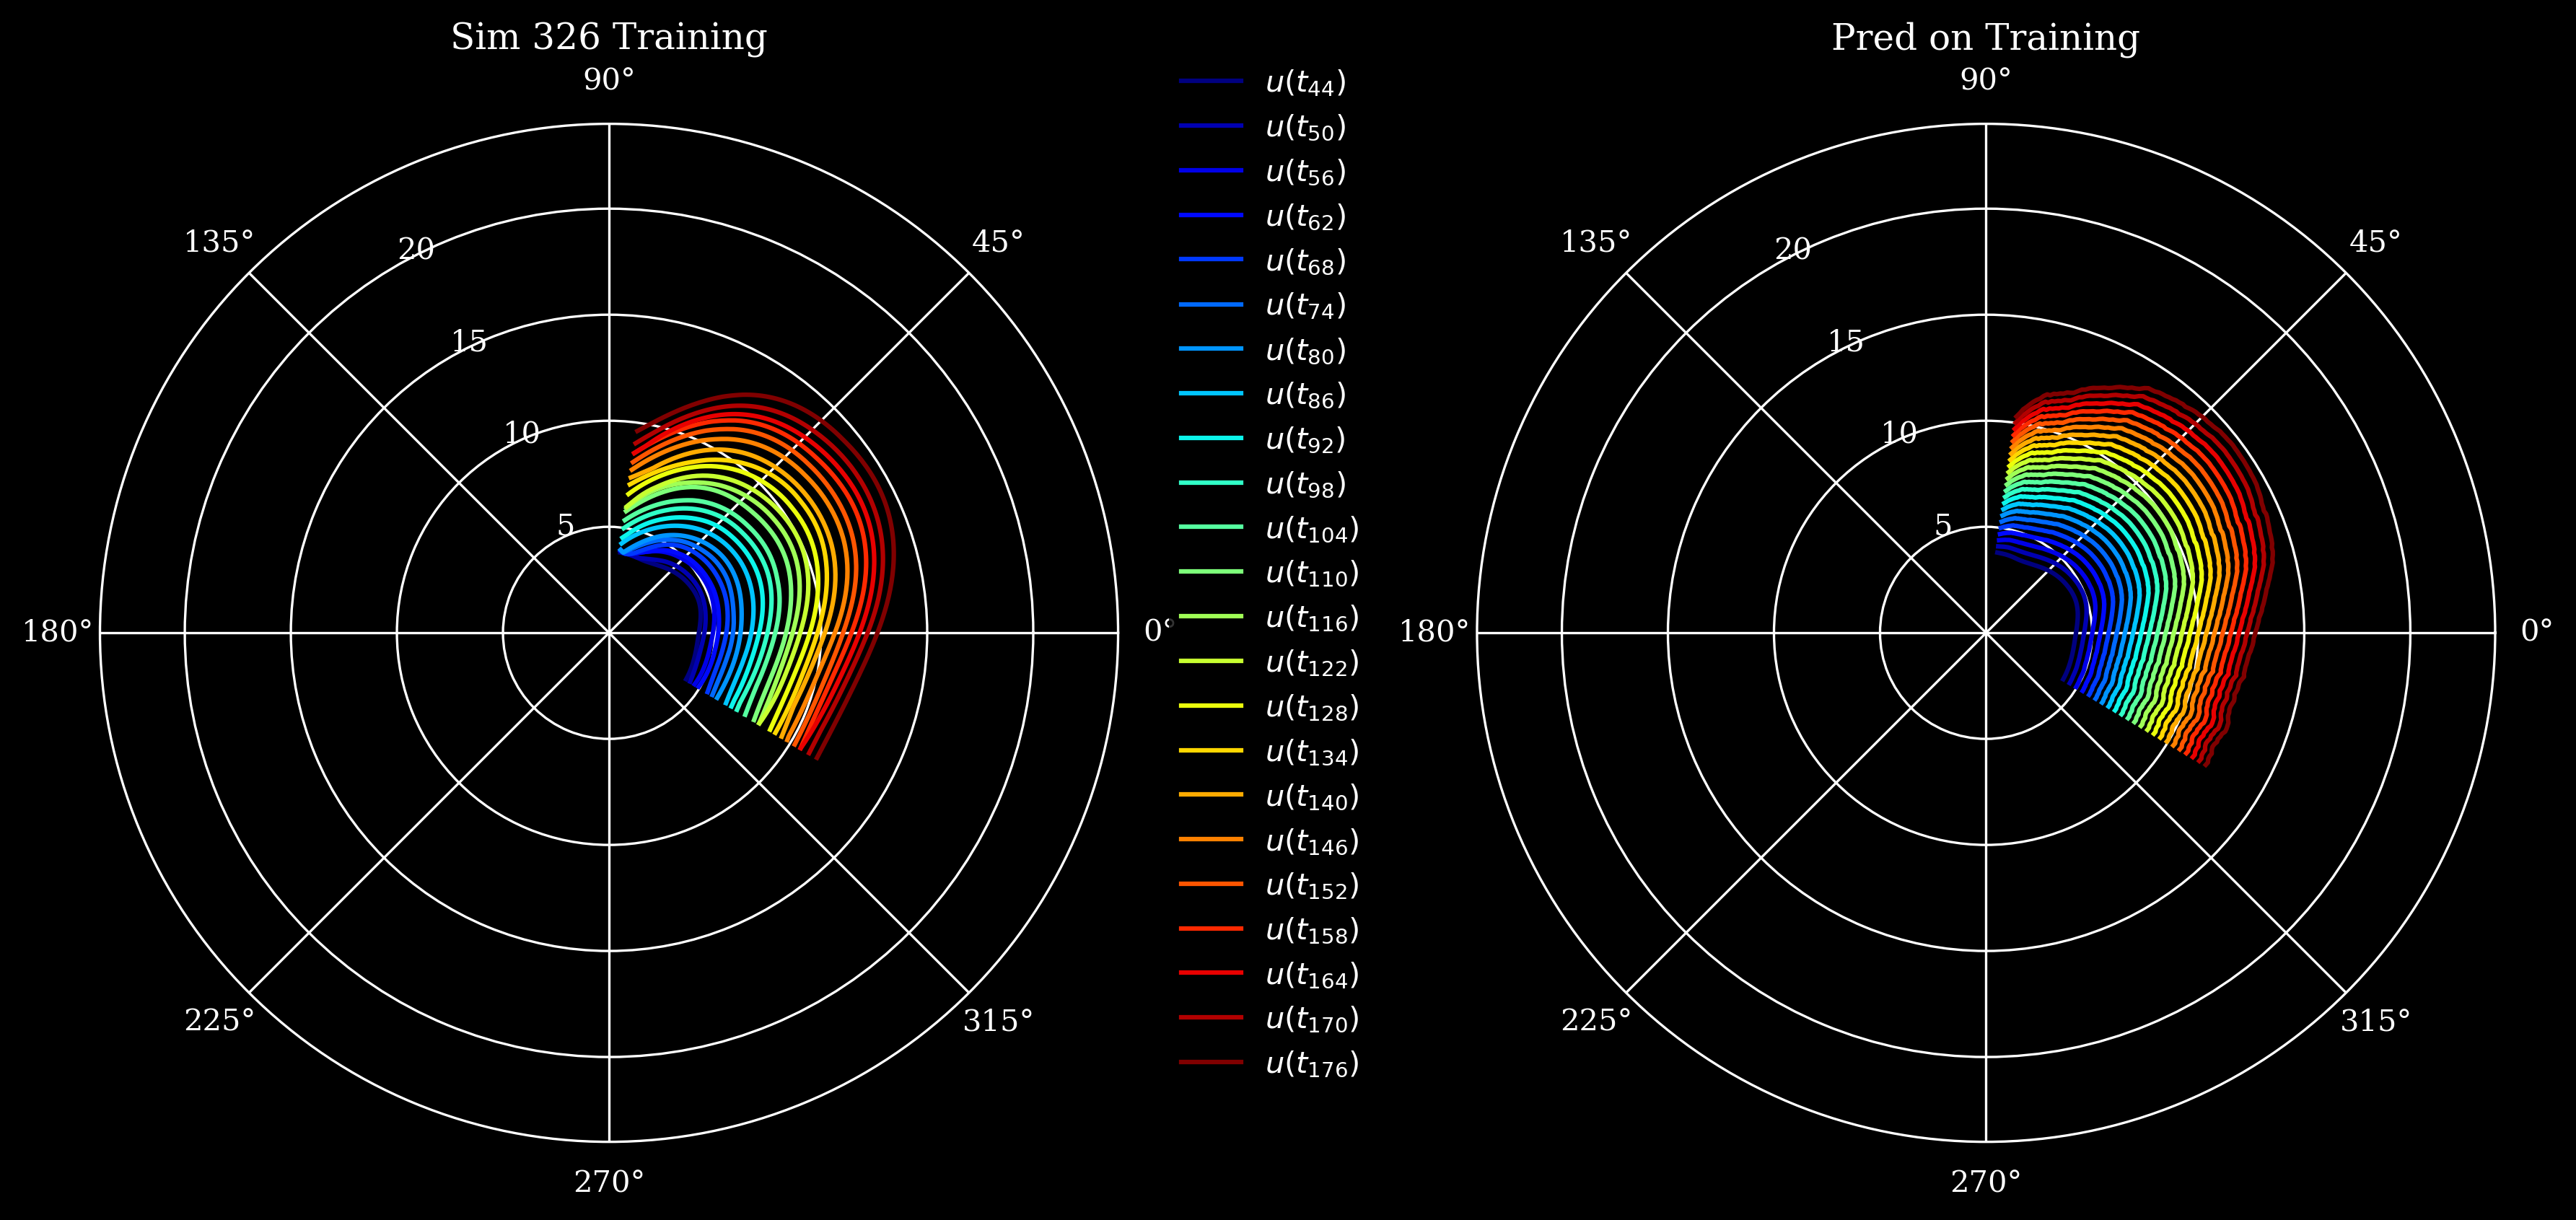

In [81]:
edut.plotTrainPredData(yf1_np, 
                       yt_pred_np, 
                       ed_2161, 
                       sd_2161, 
                       theta=np.linspace(-31, 82, 160),
                       simIdx=si1, 
                       savefig=False)

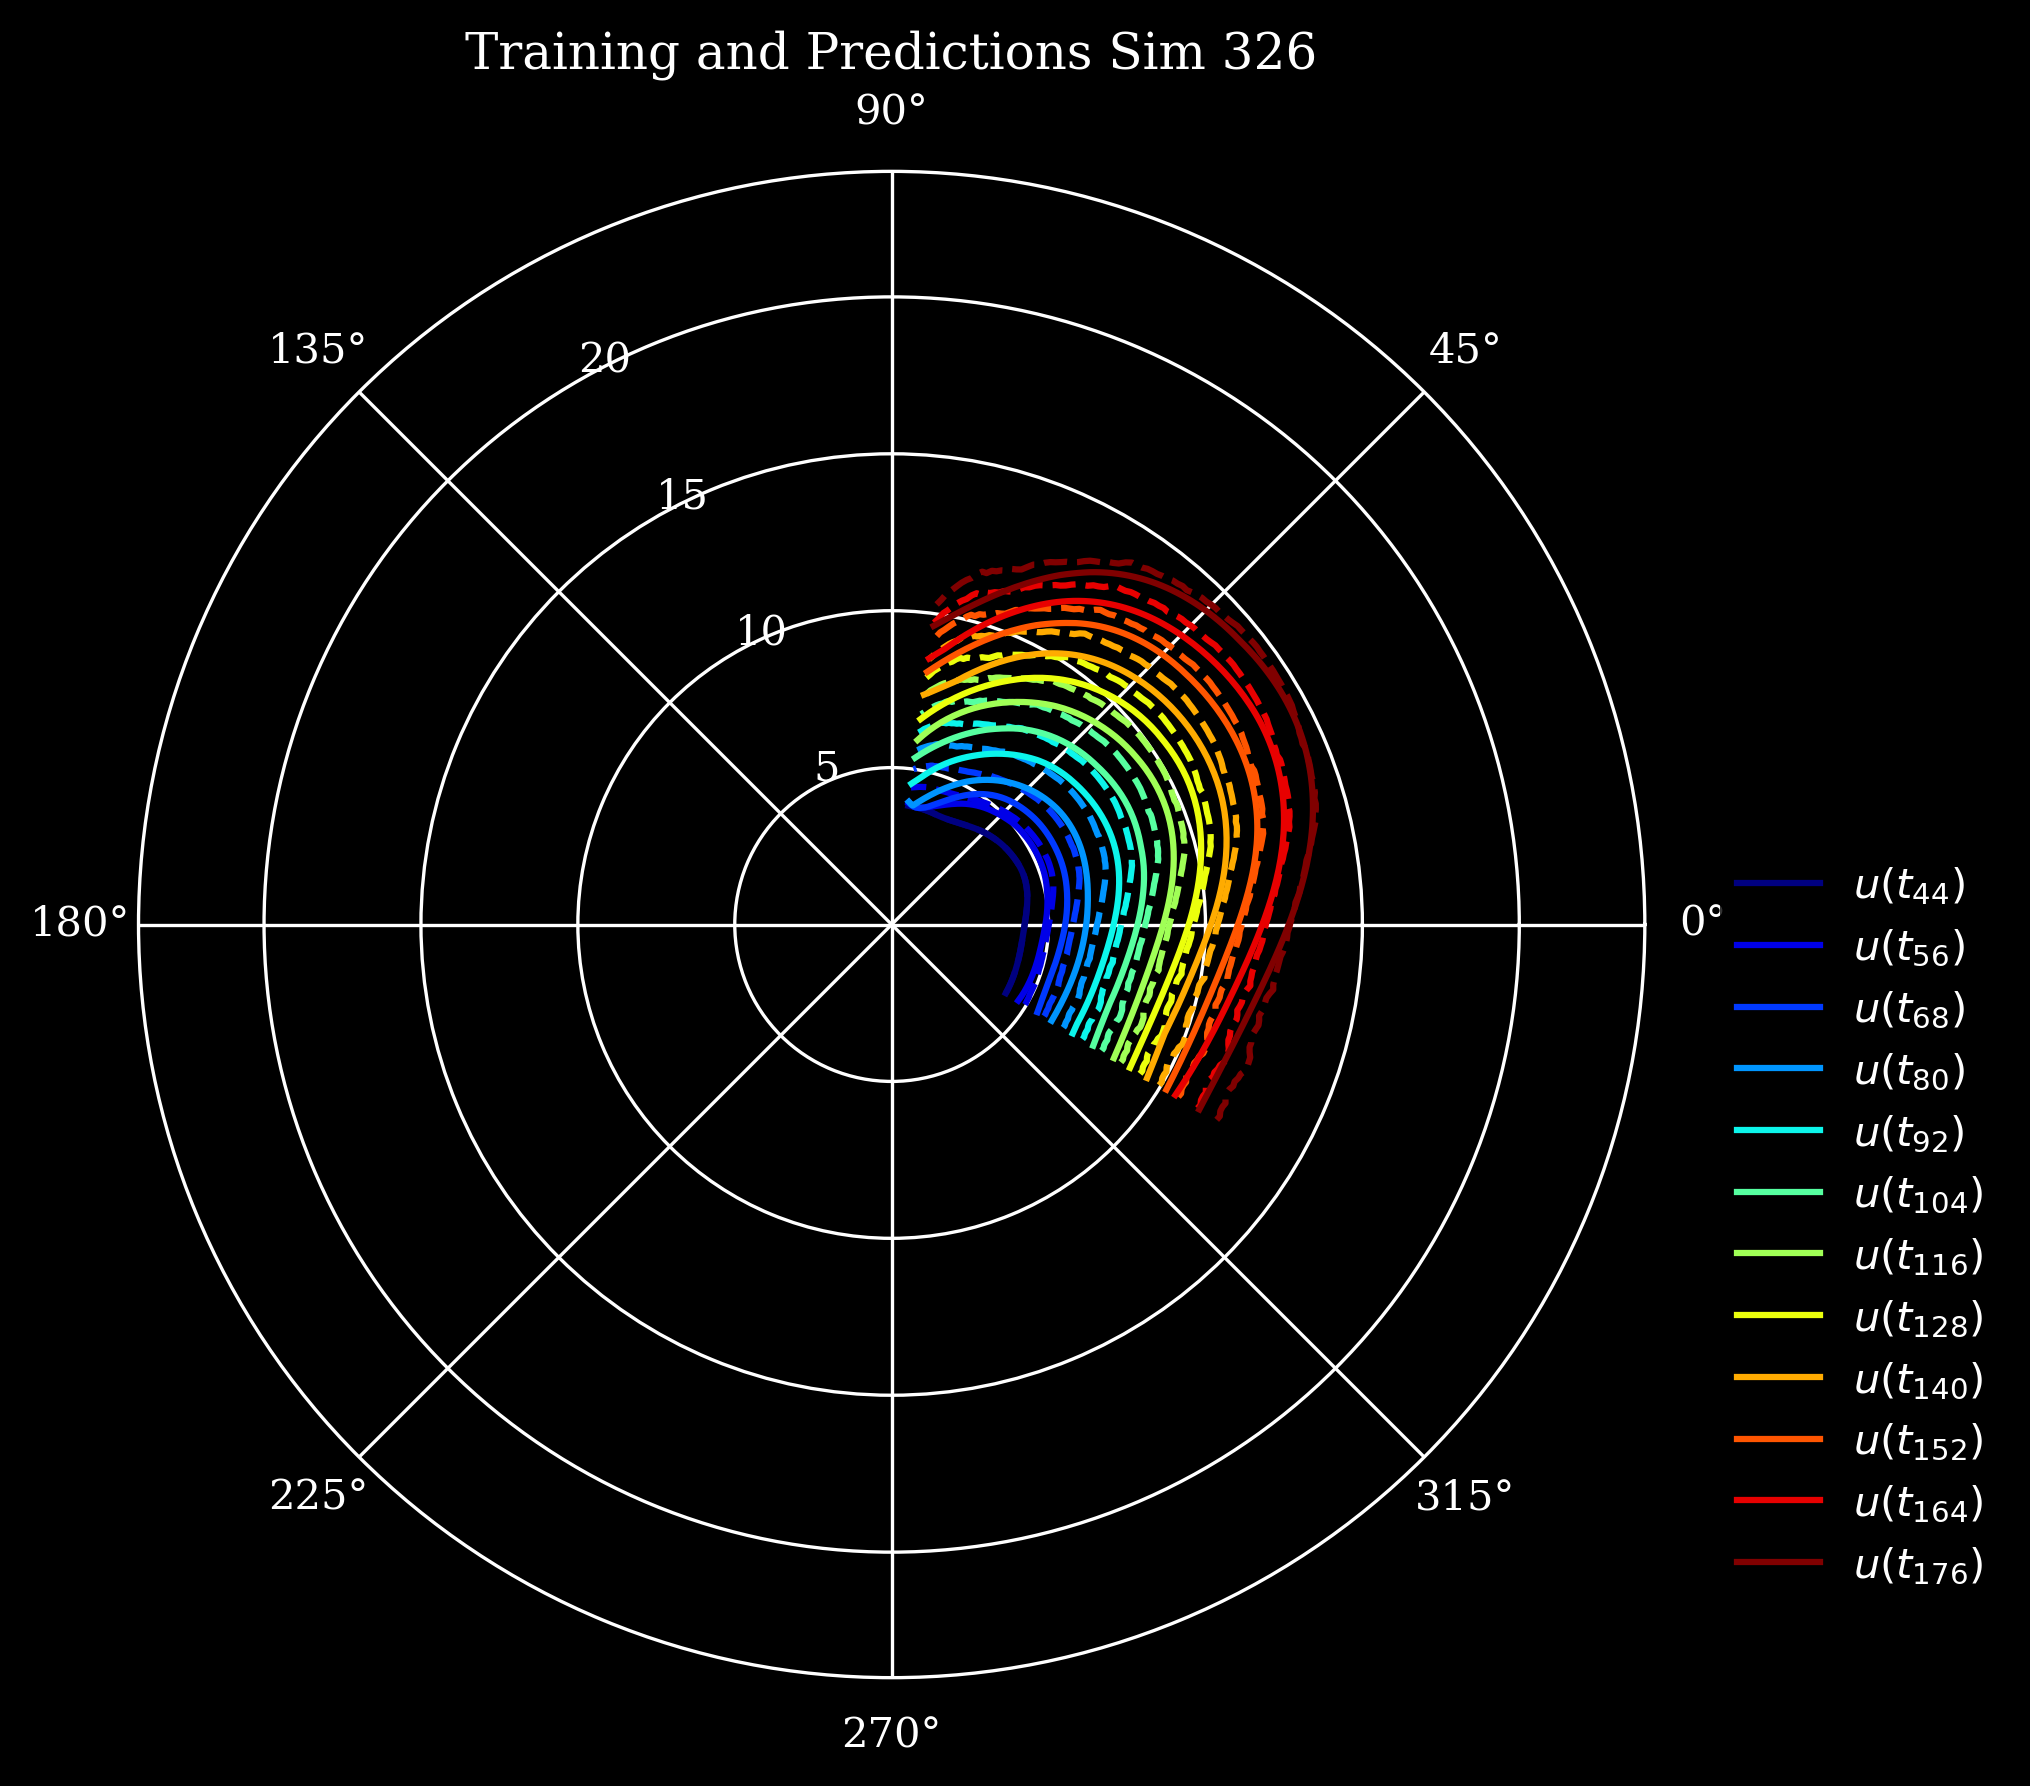

In [82]:
edut.plotTrainPredData1Model(yf1_np,
                             yt_pred_np,
                             ed_2161,
                             sd_2161,
                             theta=np.linspace(-31, 82, 160), 
                             simIdx=si1,
                             savefig=False)

In [83]:
y02, yt2, yf2, tt2, ts2, si2 = getDataForSim(ed_2161, augmented_r, sd_2161, 70)

In [84]:
si2

38

In [86]:
yt2.shape

torch.Size([39, 1, 169])

In [87]:
ts2.shape

torch.Size([59])

In [88]:
with torch.no_grad():
    yt_pred_70 = odeint(func, y02, ts2)

In [89]:
yf2_np = yf2.cpu().numpy()[:, 0, :input_dim]
yt_pred2_np = yt_pred_70.cpu().numpy()[:, 0, :input_dim]

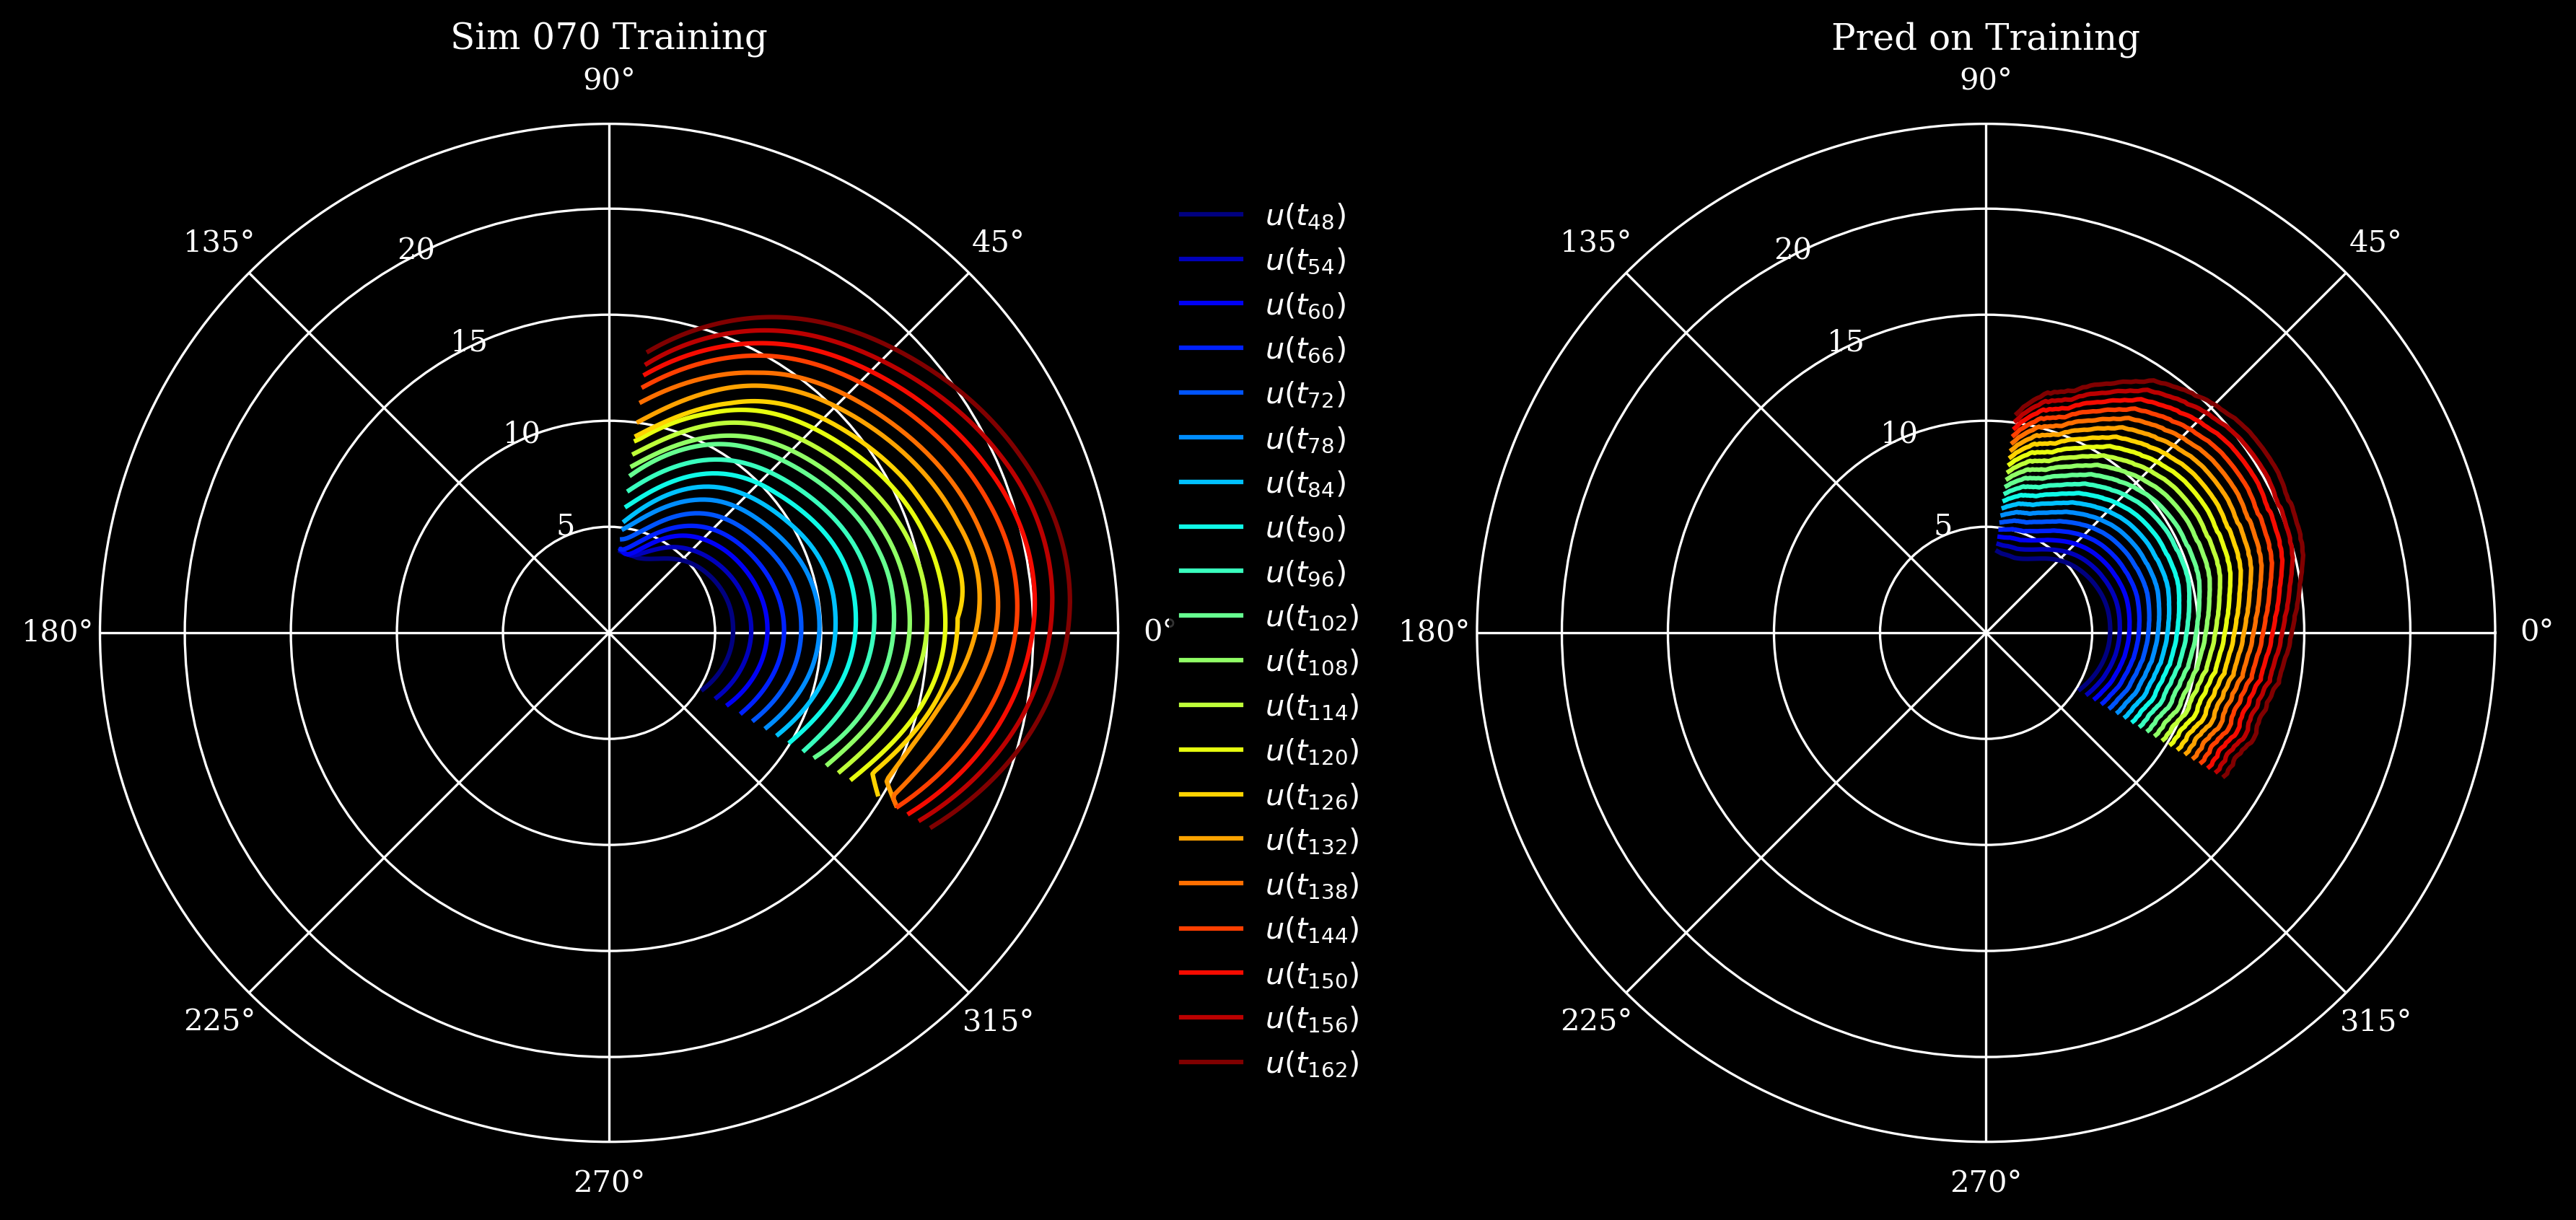

In [90]:
edut.plotTrainPredData(yf2_np, 
                       yt_pred2_np, 
                       ed_2161, 
                       sd_2161, 
                       theta=np.linspace(-31, 82, 160),
                       simIdx=si2, 
                       savefig=False)

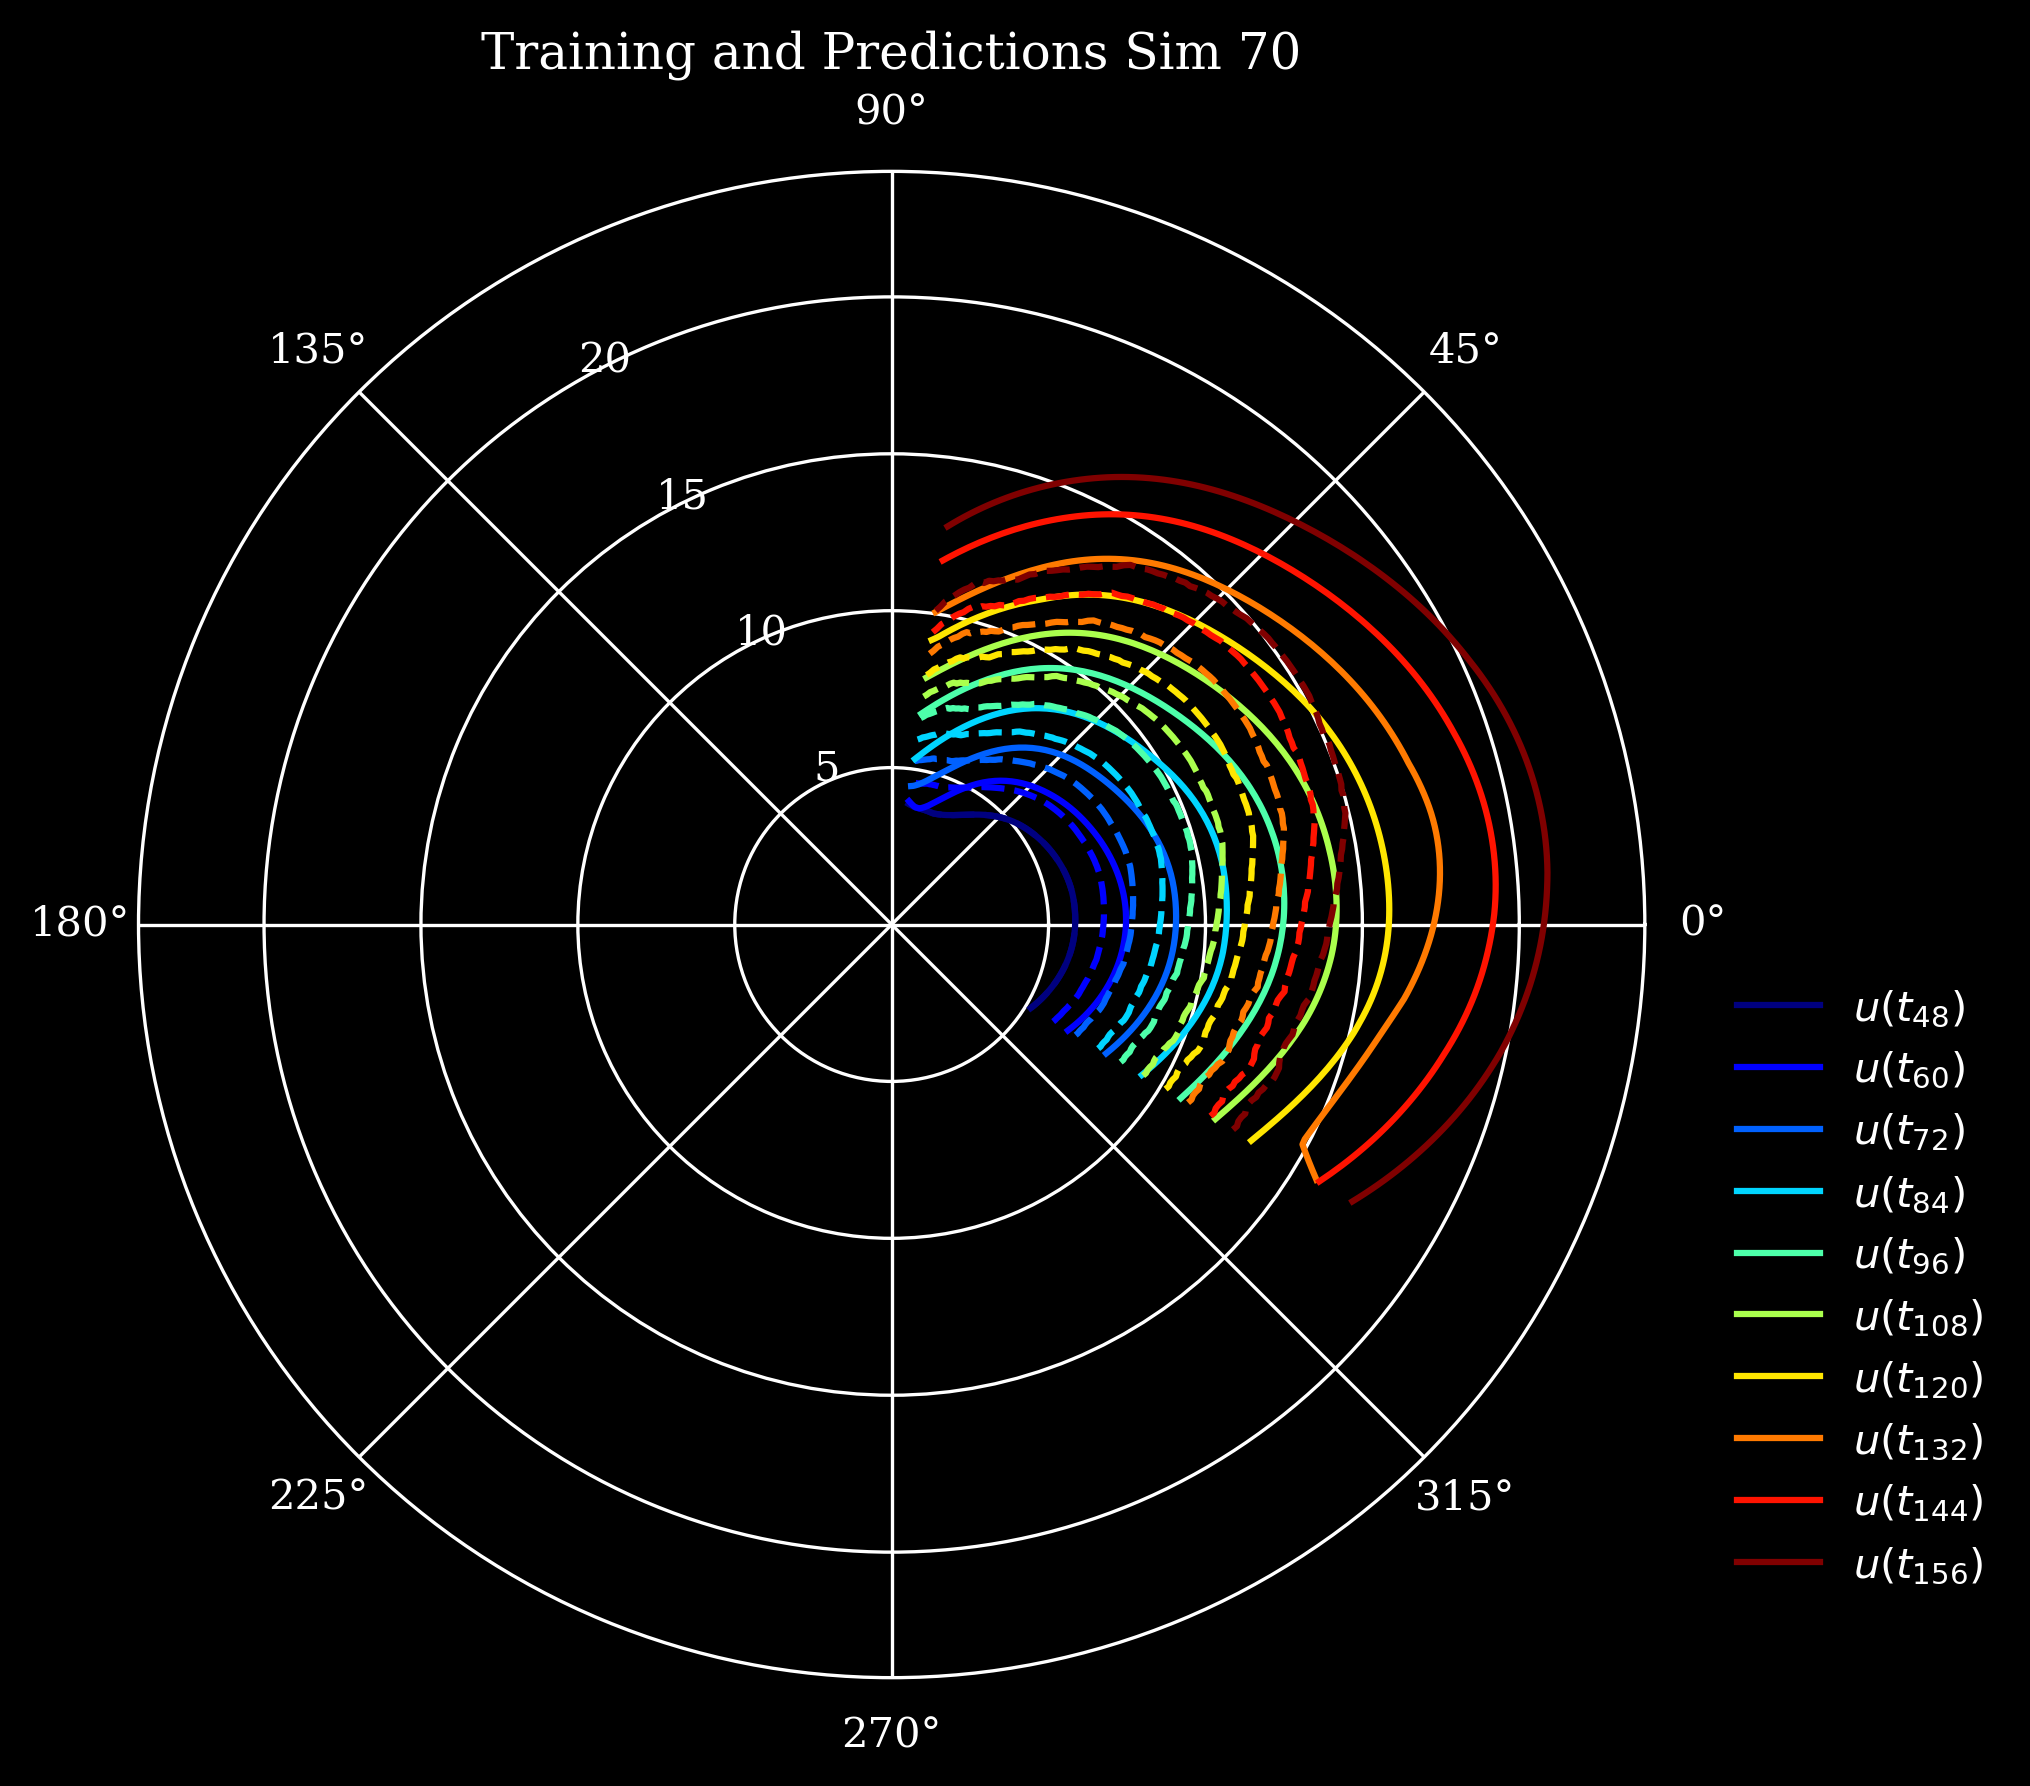

In [91]:
edut.plotTrainPredData1Model(yf2_np,
                             yt_pred2_np,
                             ed_2161,
                             sd_2161,
                             theta=np.linspace(-31, 82, 160), 
                             simIdx=si2,
                             savefig=False)

In [ ]:
save_test_preds=False

In [93]:
if save_test_preds:
    for ss in sd_test:
        y0_test, yt_test, yf_test, tt_test, ts_test, si_test = getDataForSim(ed_2161, augmented_r, sd_2161, ss)

        with torch.no_grad():
            yt_pred_test = odeint(func, y0_test, ts_test)

        y_test_np = yf_test.cpu().numpy()[:, 0, :input_dim]
        y_pred_np = yt_pred_test.cpu().numpy()[:, 0, :input_dim]

        edut.plotTrainPredData1Model(y_test_np,
                                 y_pred_np,
                                 ed_2161,
                                 sd_2161,
                                 theta=np.linspace(-31, 82, 160), 
                                 simIdx=si_test,
                                 savefig=True,
                                 savedir="./test_data_notebook_05_global_model/")

Saved image for Sim 036
Saved image for Sim 047
Saved image for Sim 058
Saved image for Sim 070
Saved image for Sim 081
Saved image for Sim 086
Saved image for Sim 090
Saved image for Sim 093
Saved image for Sim 094
Saved image for Sim 096
Saved image for Sim 097
Saved image for Sim 102
Saved image for Sim 103
Saved image for Sim 118
Saved image for Sim 127
Saved image for Sim 130
Saved image for Sim 132
Saved image for Sim 133
Saved image for Sim 139
Saved image for Sim 147
Saved image for Sim 158
Saved image for Sim 159
Saved image for Sim 160
Saved image for Sim 162
Saved image for Sim 169
Saved image for Sim 179
Saved image for Sim 180
Saved image for Sim 184
Saved image for Sim 203
Saved image for Sim 214
Saved image for Sim 223
Saved image for Sim 229
Saved image for Sim 231
Saved image for Sim 235
Saved image for Sim 240
Saved image for Sim 246
Saved image for Sim 254
Saved image for Sim 258
Saved image for Sim 259
Saved image for Sim 262
Saved image for Sim 263
Saved image for 